
# Image Captioning with **Qwen 2.5-VL**

This notebook shows how to:
1. load the 3-B-parameter **Qwen 2.5-VL-Instruct** model,  
2. send an image plus a natural-language request in “chat” format,  
3. receive an AI-generated caption, and  
4. visualise both the input image and the caption.  

*Runtime note:* The model uses ~6 GB VRAM in float-16 mode. If you are on a GPU without enough memory, set `device_map="cpu"` instead of `"auto"`.




## 1  Install necessary packages


In [1]:
!pip install qwen-vl-utils  # Upgrade Qwen-VL utilities



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


## 2  Imports

In [1]:
# ── Standard library ────────────────────────────────────────────
import os          # File‑system helpers (paths, env vars, etc.)
import random      # Lightweight randomness (e.g. sample prompts)
import textwrap    # Nicely format long strings for display
import io          # In‑memory byte streams (e.g. image buffers)
import requests    # Simple HTTP requests for downloading assets

# ── Numerical computing ─────────────────────────────────────────
import numpy as np  # Core array maths (fast, vectorised operations)

# ── Deep‑learning stack ─────────────────────────────────────────
import torch  # Tensor library + GPU acceleration
from transformers import (
    Qwen2_5_VLForConditionalGeneration,  # Multimodal LLM (image+text)
    AutoProcessor,                       # Paired tokenizer/feature‑extractor
)

# ── Imaging & visualisation ─────────────────────────────────────
from PIL import Image                    # Pillow: load/save/manipulate images
import matplotlib.pyplot as plt          # Quick plots in notebooks
import matplotlib.patches as patches     # Bounding‑box overlays, etc.

# ── Project‑specific helpers ────────────────────────────────────
from qwen_vl_utils import process_vision_info  # Post‑process Qwen outputs

# ── Notebook conveniences ──────────────────────────────────────
import IPython.display as ipd             # Inline display (images, audio, HTML)


c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3  Device & model load

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "Qwen/Qwen2.5-VL-3B-Instruct"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype="auto",     # automatically uses FP16 on GPU, FP32 on CPU
    device_map="auto"       # dispatches layers to the available device(s)
)
processor = AutoProcessor.from_pretrained(model_id)

print(f"Model loaded on: {model.device}")


Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]
Some parameters are on the meta device because they were offloaded to the cpu.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded on: cuda:0


## 4  Fetch or upload an image
Here we download a sample image from Unsplash, but you can replace the URL or upload your own file.


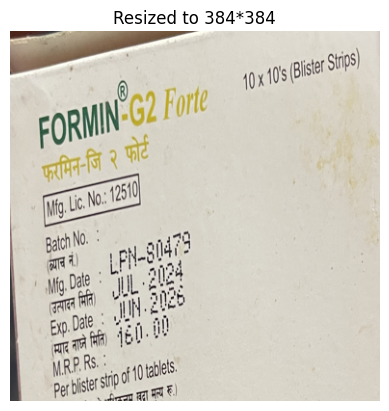

In [44]:
# url = "https://5.imimg.com/data5/SELLER/Default/2024/12/470701946/SV/IX/FJ/23618296/glimepiride-2-mg-tablet-500x500.jpeg"
# img = Image.open(io.BytesIO(requests.get(url, timeout=15).content)).convert("RGB")
# Open and resize the image
img = Image.open("IMG_5811.JPG").resize((384, 384))

# Display the resized image
plt.imshow(img)
plt.axis("off")
plt.title("Resized to 384*384")
plt.show()


## 5  Build a chat-style prompt
### 5.1 Create a message in JSON format
Qwen VL uses the same multi-turn message format as Qwen-2.5-Chat:
 ```python
 msgs = [
     { "role": "user",
       "content": [
           {"type": "image", "image": img},
           {"type": "text",  "text": "Describe this image."}
       ],
     }
 ]
 ```
The processor turns these messages into plain text (with special tokens) and extracts the visual tensors so the model receives *both* modalities.

In [45]:
msgs = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": img},
            {"type": "text",  "text": "Give Name of medicine, Mfg. Date, Exp Date, MRP Rs"}
        ],
    }
]

### 5.2 Apply Chat Template
Every chat model ships with a pattern. The above JSON format needs to be converted to this template and this is done using `apply_chat_template`. It performs three tasks.
1. **Reads the model’s chat template**: Qwen 2.5VL has a chat template that looks like `<|im_start|>{role}\n{content}<|im_end|>`.
2. **Fills in the template with the msgs list**. It loops over each message, swaps in the role (user, assistant, etc.) and the content (text plus special <image> markers), and concatenates the result into one long string.
3. **Adds the “assistant starts talking now” marker** (add_generation_prompt=True). At the end it appends `<|im_start|>assistant`

We have also instructed it to NOT tokenize the text because we are going to use the processor to process text and images together, and tokenization will be performed in that step.


In [46]:
# Build the full textual prompt that Qwen-VL expects
# --------------------------------------------------
# • msgs : list of message dicts (roles + content, including <image> markers)
# • tokenize=False : return a plain string—not token IDs—so we can
#                    combine it with image tensors in the next processor() call
# • add_generation_prompt=True : appends the “assistant is about to speak” marker
#                                (e.g. "<|im_start|>assistant\n"), which tells the
#                                model where its reply should begin.
text_prompt = processor.apply_chat_template(
    msgs,
    tokenize=False,
    add_generation_prompt=True
)

# For sanity-checking: print the raw prompt string that will be fed to the model
print(text_prompt)


<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Give Name of medicine, Mfg. Date, Exp Date, MRP Rs<|im_end|>
<|im_start|>assistant



### 5.3 Extract image & video inputs from `msg`

In the previous step we converted our message `msg` from JSON format to the chat template the model understands.

Now, we need to extract images and videos from `msg` using `process_vision_info` utility. It performs the following tasks
1. Walks through every message,
2. Finds all `"image"` / `"video"` entries,
3. Applies the Qwen-VL visual pre-processing to ensure each image is a PIL.Image (or each video is a list / tensor of frames).
4. Returns two parallel lists/tensors
 - `image_inputs`  → batched image tensors (or [] if none)
 - `video_inputs`  → batched video tensors (or [] if none)

In [47]:
# Extract vision-modalities from msgs and convert them to model-ready tensors
# --------------------------------------------------------------------------
# • msgs : the same chat-style list you fed to apply_chat_template.
#          Each dict can include items like {"type": "image", "image": img}
#          or {"type": "video", "video": video_clip}.
# • process_vision_info : project utility that
#       1) walks through every message,
#       2) finds all `"image"` / `"video"` entries,
#       3) applies the Qwen-VL visual pre-processing to ensure each
#          image is a PIL.Image (or each video is a list / tensor of frames).
#       4) returns two parallel lists/tensors:
#            – `image_inputs`  → batched image tensors (or [] if none)
#            – `video_inputs`  → batched video tensors (or [] if none)
#   These outputs plug straight into the `processor(...)` call that follows,
#   ensuring the vision data is aligned with the text prompt.
image_inputs, video_inputs = process_vision_info(msgs)


## 6  Generate the caption

### 6.1 Run inference

In [48]:
# ── Pack text + vision into model-ready tensors ──────────────────────────────
inputs = processor(
    text=[text_prompt],      # 1-element batch containing the chat prompt string
    images=image_inputs,     # list of raw PIL images (pre-processed inside processor)
    videos=video_inputs,     # list of raw video clips (if any)
    padding=True,            # pad sequences so text/vision tokens line up in a batch
    return_tensors="pt",     # return a dict of PyTorch tensors (input_ids, pixel_values, …)
).to(model.device)           # move every tensor—text & vision—to the model’s GPU/CPU

# ── Run inference (no gradients, pure generation) ───────────────────────────
with torch.no_grad():                     # disable autograd to save memory
    generated_ids = model.generate(       # autoregressive decoding
        **inputs,                         # unpack dict into generate(...)
        max_new_tokens=64                 # cap the response at 64 tokens
    )
print(inputs.input_ids[0])
print(generated_ids)

tensor([151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
        151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
        151655, 151655, 151655, 151655, 

### 6.2 Decode output

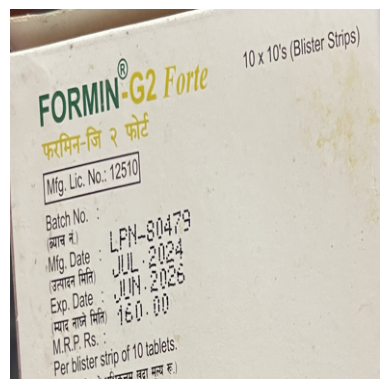

The name of the medicine is "FORMIN-G2 Forte." The manufacturing date is June
2024 (JULN 2024), and the expiration date is June 2026 (JUN 2026). The
manufacturer's reference number is LPN-S1


In [49]:
# Extract the newly generated tokens (skip the prompt length)
caption = processor.batch_decode(
    generated_ids[:, inputs.input_ids.shape[-1]:],
    skip_special_tokens=True
)[0]

# Display the image
plt.imshow(img)
plt.axis("off")
plt.show()

# Print caption
width = 80
wrapped_caption = textwrap.fill(caption, width)
print(wrapped_caption)
